In [189]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt

In [190]:
!pip3 install seaborn

In [191]:
from graph_world.beam.generator_config_sampler import ParamSamplerSpec
from graph_world.sbm.beam_handler import SampleSbmDoFn, ConvertToTorchGeoDataParDo

In [192]:
FEATURE_CENTER_DISTANCE = 3.0
POWER_EXPONENT = 0.5
P2Q = 25.0
CLUSTER_SIZE_SLOPE = 1.0
TAG = 'heterogeneous'
i = 0

In [193]:
FEATURE_CENTER_DISTANCE = 0.05
POWER_EXPONENT =1.0
P2Q = 5.0
CLUSTER_SIZE_SLOPE = 0.0
TAG = 'homogeneous'
i = 0

In [194]:
# Get graph data
param_sampler_specs = [
    ParamSamplerSpec(name="nvertex",
                     min_val=640,
                     max_val=640),
    ParamSamplerSpec(name="p_to_q_ratio",
                     min_val=P2Q,
                     max_val=P2Q),
    ParamSamplerSpec(name="avg_degree",
                     min_val=10,
                     max_val=10),
    ParamSamplerSpec(name="feature_dim",
                     min_val=16,
                     max_val=16),
    ParamSamplerSpec(name="feature_center_distance",
                     min_val=FEATURE_CENTER_DISTANCE,
                     max_val=FEATURE_CENTER_DISTANCE),
    ParamSamplerSpec(name="edge_center_distance",
                     min_val=2.0,
                     max_val=2.0),
    ParamSamplerSpec(name="edge_feature_dim",
                     min_val=2.0,
                     max_val=2.0),
    ParamSamplerSpec(name="num_clusters",
                     min_val=4,
                     max_val=4),
    ParamSamplerSpec(name="cluster_size_slope",
                     min_val=CLUSTER_SIZE_SLOPE,
                     max_val=CLUSTER_SIZE_SLOPE),
    ParamSamplerSpec(name="power_exponent",
                     min_val=POWER_EXPONENT,
                     max_val=POWER_EXPONENT),
]
sampler_dofn = SampleSbmDoFn(param_sampler_specs)
sampler_out = next(sampler_dofn.process(sample_id=0))

In [195]:
graph = sampler_out['data'].graph
memberships = sampler_out['data'].graph_memberships
features = sampler_out['data'].node_features
degrees = graph.get_out_degrees(graph.get_vertices())
num_removed = 0
for i, d in enumerate(degrees):
    if d == 0:
        graph.remove_vertex(i - num_removed)
        memberships = np.delete(memberships, [i - num_removed])
        features = np.delete(features, [i - num_removed], axis=0)
        num_removed += 1

In [196]:
len(list(graph.vertices()))

618

In [197]:
cmap = plt.cm.tab10
cmaplist = [cmap(i) for i in range(cmap.N)]
print(cmaplist)

pmaps = []

pmap = graph.new_vertex_property("vector<double>")
for v in graph.vertices():
    member = memberships[int(v)]
    pmap[v] = cmaplist[member]

pmaps.append(pmap)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


In [198]:
import os
outdir="/tmp/graph_plots"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
i = 0
gt.graph_draw(graph, vertex_fill_color=pmaps[i], output=outdir + "/graph_%s.png" % TAG)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f45c8049828, at 0x7f45e07d70f0>

/opt/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


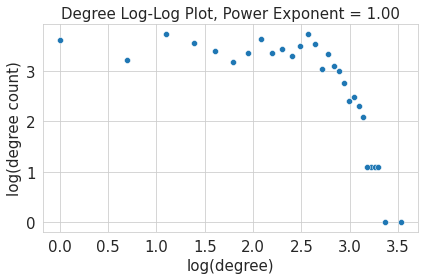

In [199]:
#@title Plot log-log degrees
import collections
import seaborn as sns
degrees = np.array(graph.get_out_degrees(graph.get_vertices()))
degree_counts = collections.Counter(degrees)
degree_vals, degree_counts = zip(*degree_counts.items())
degree_vals = [np.log(x) for x in degree_vals]
degree_counts = [np.log(x) for x in degree_counts]
ax = sns.scatterplot(degree_vals, degree_counts)
# ax.set_xscale('log10')
# ax.set_yscale('log10')
ax.set_title('Degree Log-Log Plot, Power Exponent = %0.2f' % POWER_EXPONENT, fontsize=15)
ax.set_xlabel('log(degree)', fontsize=15)
ax.set_ylabel('log(degree count)', fontsize=15)
plt.tight_layout()
plt.savefig(outdir + "/degrees_%s.png" % TAG)

In [200]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

def plot_2d_embeddings(input_embeddings,
                       label_matrix,
                       title='Title Here',
                       top=10,
                       reverse=True,
                       plot_size=12,
                       pntsize=6,
                       do_legend=False,
                       show_axes=True,
                       wrap_points=False,
                       titlesize=4,
                       subtitle='',
                       ticksize=16,
                       filename=None):
  """Plot 2d embeddings.
  Args:
    input_embeddings: input embeddings
    label_matrix: label matrix
    title: plot title
    top: number of categories to take
    reverse: reverse category sort
    plot_size: plot size
    pntsize: scatterplot point size
    do_legend: plot legend
    show_axes: show axes
    wrap_points: wrap points
    titlesize: title size
    subtitle: subtitle
    ticksize: tick size
    filename: filename
  Returns: (none)
  """
  # Filter samples with no labels
  retained_samples = numpy.argwhere(numpy.sum(label_matrix, axis=1))[:, 0]
  x1 = input_embeddings[retained_samples, 0]
  x2 = input_embeddings[retained_samples, 1]
  label_matrix = label_matrix[retained_samples, :]
  labels = [p[1] for p in list(numpy.argwhere(label_matrix))]

  # Filter the label set if necessary
  if len(set(labels)) > top:
    item_counts = dict([(label, labels.count(label)) for label in set(labels)])
    sorted_counts = sorted(
        item_counts.items(), key=operator.itemgetter(1), reverse=reverse)
    good_labels = set()
    for entry in sorted_counts[:top]:
      good_labels.add(entry[0])

    x1 = numpy.array(
        [x1[ii] for ii in range(len(labels)) if labels[ii] in good_labels])
    x2 = numpy.array(
        [x2[ii] for ii in range(len(labels)) if labels[ii] in good_labels])
    good_example_labels = [label for label in labels if label in good_labels]
    labels = good_example_labels

  # Split the data into groups
  label_set = set(labels)
  data_groups = [None] * len(label_set)
  for ii, label in enumerate(label_set):
    indx = [j for j in range(len(labels)) if labels[j] == label]
    data_groups[ii] = (x1[indx], x2[indx])

  # Make the plot
  fig = plt.figure(figsize=(plot_size, plot_size))
  if wrap_points:
    plt.xlim(numpy.min(x1), numpy.max(x1))
    plt.ylim(numpy.min(x2), numpy.max(x2))
  ax = fig.add_subplot(1, 1, 1)
  for ii, data_group in enumerate(data_groups):
    x, y = data_group
    ax.scatter(x, y, s=pntsize, c=cmaplist[ii], edgecolors='none', label=ii)
  if not subtitle:
    plt.title(title, fontsize=titlesize)
  else:
    plt.suptitle(title, fontsize=titlesize)
    plt.title(subtitle)

  if do_legend:
    plt.legend(loc=1)

  # Modify axes
  frame1 = plt.gca()
  frame1.axes.get_xaxis().set_visible(show_axes)
  frame1.axes.get_yaxis().set_visible(show_axes)
  plt.rc('xtick', labelsize=ticksize)
  plt.rc('ytick', labelsize=ticksize)

  # Save or plot
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
  else:
    plt.show()

In [201]:
# Construct party labels
party_labels = numpy.zeros(shape=(len(memberships), len(set(memberships))))
for i, l in enumerate(memberships):
  party_labels[i, l] = 1.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

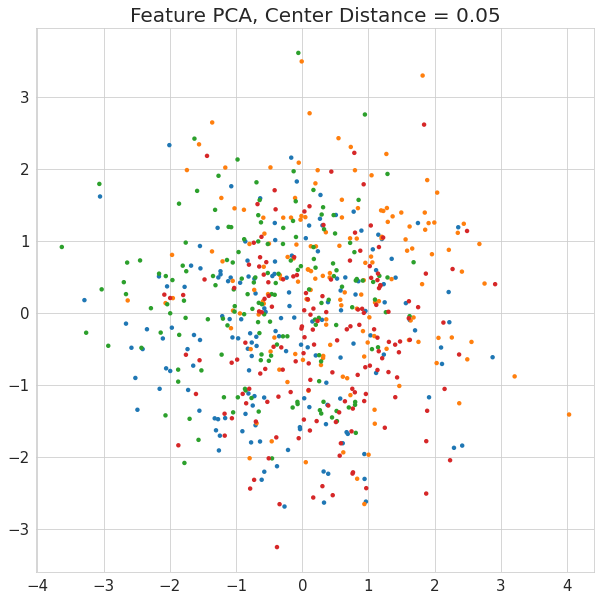

In [202]:
# Plot TSNE for standard glove
glove_tsne = PCA(n_components=2).fit_transform(features)
sns.set_style('whitegrid')
COLORS = ['red', 'blue', 'orange', 'green']
plot_2d_embeddings(
    glove_tsne,
    party_labels,
    title='Feature PCA, Center Distance = %0.2f' % FEATURE_CENTER_DISTANCE,
    subtitle='',
    pntsize=20,
    plot_size=10,
    filename=os.path.join('/tmp/graph_plots', 'features_%s.png' % TAG),
    show_axes=True,
    wrap_points=False,
    ticksize=15,
    titlesize=20)